<a href="https://colab.research.google.com/github/vbwanere/SEDS_in_jax/blob/main/gmr_lib/GMR_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GMR and SEDS using constrained GMR**

# 1\. Introduction:

We estimate a joint density of the inputs $x\  \epsilon \ \mathbb R^N$ and outputs $\dot x \ \epsilon \ \mathbb R^P$ through a K-component Gaussian mixture model as follows:

\begin{equation}
\tag{1}
p(x, \dot x|\Theta) = \sum_{k=1}^{K} \pi_k p(x, \dot x|\mu^k \Sigma^k)
\end{equation}

where,\
$\sum_{k=1}^{K} \pi_k = 1$ and $\mu^k = \begin{bmatrix}
\mu_{x}^{k}\\
\mu_{\dot x}^{k}
\end{bmatrix}$,
and $\ \Sigma^k =
\begin{bmatrix}
\Sigma_{xx}^{k} & \Sigma_{x\dot x}^{k} \\
\Sigma_{\dot xx}^{k} & \Sigma_{\dot x \dot x}^{k}
\end{bmatrix}$.

The conditional density is given by:
\begin{equation}
\tag{2}
p(\dot x|x) = \sum_{k=1}^{K} \gamma_k p(\dot x|x, \mu^k, \Sigma^k)
\end{equation}

where,
\begin{equation}
\tag{3}
\gamma_k = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
\end{equation}

The regressive function $\dot x = f(x)$ is given by the expectation over this conditional density:
\begin{equation}
\tag{4}
\dot x = f(x) = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x)\tilde \mu^k(x)
\end{equation}

where,
\begin{equation}
\tag{5}
\tilde \mu = \mu_{\dot x}^k + \Sigma_{\dot x x}^k(\Sigma_{x x}^k)^{-1}(x - \mu_x^k)
\end{equation}

If we use change of variable and define:

\begin{equation}
\tag{6}
\!
\begin{aligned}
A^k & = \Sigma_{\dot x x}^k(\Sigma_{x}^k)^{-1}\\
b^k & = \mu_{\dot x}^k - A^k \mu_x^k\\

\gamma_k & = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}\\
\end{aligned}
\end{equation}

Substituting (6) in (4) and using (5) yields:

\begin{equation}
\tag{7}
\!
\begin{aligned}
\dot x & = f(x; \Theta_{GMR})\\
& = \mathbf E[p(\dot x|x)] = \sum_{k=1}^{K} \gamma_k(x) (A^k x + b^k)
\end{aligned}
\end{equation}

Also, we can write a non linear dynamical system as a mixture of linear dynamical systems as follows:

\begin{equation}
\tag{8}
\!
\begin{aligned}
\dot x & = f(x)\\
& = \sum_{k=1}^{K} \gamma_k(x) (A^k_x + b^k)
\end{aligned}
\end{equation}

where $A^k \ \epsilon \ \mathbb{R^N}$ and $b^k \ \epsilon \ \mathbb{R^N}$ are the k-th linear system parameters. $\gamma_k(x): \mathbb{R^N} \rightarrow \mathcal{R}$ is the mixing function, also referred to as the activation function. Please refer to the figure below:

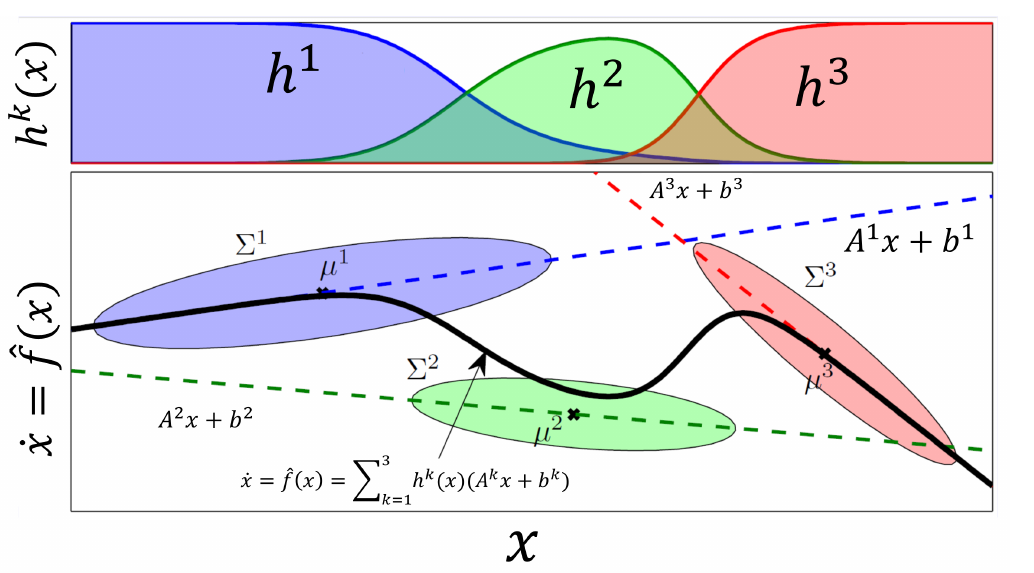\
Figure: Illustration of parameters defined in (6) and their effects on $f(x)$ for a 1-D model\
constructed with 3 Gaussians. $h(x)$ is the activation function.

## 1.1 Undestanding the dataset:

1. Inputs $x \ \epsilon \ \mathbb R^N$, for $M$ number of trajectories with each of length $T_m$, we have, for $m^{th}$ trajectory:
\begin{equation}
X_m =
\begin{bmatrix}
x_1^1 & x_1^2 & ....... & x_1^{T_m}\\
& & &\\
x_N^1 & x_N^2 & ....... & x_N^{T_m}\\
\end{bmatrix}
\end{equation}

where, $m \ \epsilon \  \{1,....,M\}$, and $\{\mathbf X, \dot{\mathbf X}\} = \{X^m, \dot X^m\}_{m=1}^{M} = \{\{{x^{t,m}, {\dot x^{t,m}}\}_{t=1}^{T_m}}\}_{m=1}^{M}$.

In our python implementation, the $X^m$ is an array of shape $(N, T^m)$ and the dataset for all trajectories is a list with $M$ such arrays.

# 2. Using `gmr` library:

In [1]:
import numpy as np
# import jax.numpy as jnp
# from jax import grad, jacfwd, jit, random, vmap
# from jax.scipy.stats import multivariate_normal
from sklearn import mixture
import scipy
import scipy.io
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
import os

Please refer to the [this GMR library by Alexander Fabisch](https://github.com/AlexanderFabisch/gmr).

In [2]:
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses

## 2.1 Importing LASA Handwritten Dataset:
Please refer to [this python library](https://github.com/justagist/pyLasaDataset) for the [Handwritten Human Motion LASA Datset](https://www.epfl.ch/labs/lasa/datasets/).\
Please understand the dataset [here](https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt).

In [3]:
from pyLasaDataset import DataSet as lasa
from pyLasaDataset import utilities
plot_lasa = utilities.plot_model

Using LASA DataSet from /home/vbwanere/.local/lib/python3.10/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


## 2.2 Visualizing Trajectories:

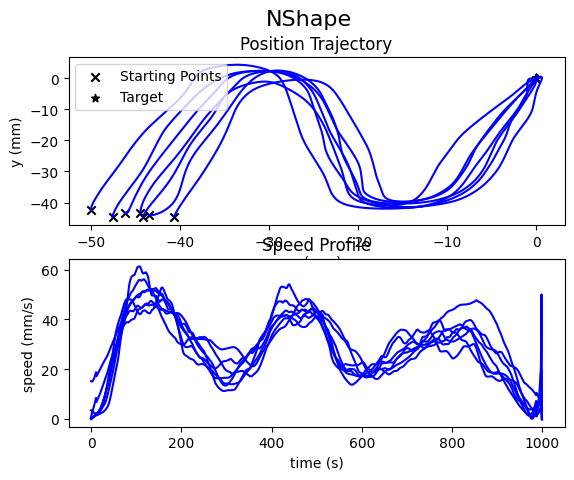

In [4]:
traj = lasa.NShape
plot_lasa(traj)

## 2.3 Fitting GMM on a given trajectory data:

#### 2.3.1 Position and Velocity Datset

In [5]:
# function: get_traj_data

def get_traj_data(trajectory_name = 'Sine'):
    """
    Returns position and velocity data of the trajectory.
    shape: (M*T, 4) --> [x_pos, y_pos, x_vel, y_vel]
    M: number of demonstrations
    T: number of time steps t=0 to t=T
    """
    traj_demos = getattr(lasa, trajectory_name).demos
    
    traj_pos = traj_demos[0].pos.T # trajectory position shape: (T, 2)
    traj_vel = traj_demos[0].vel.T # trajectory position shape: (T, 2)
    
    # positions of all demonstrations:
    for i in range(len(traj_demos)-1):
        concat_pos = np.concatenate((traj_pos, (traj_demos[i+1].pos.T)), axis= 0 )
        traj_pos = concat_pos
    
    # velocities of all demonstrations:
    for i in range(len(traj_demos)-1):
        concat_vel = np.concatenate((traj_vel, (traj_demos[i+1].vel.T)), axis= 0 )
        traj_vel = concat_vel    
    
    # trajectory position and velocity: trajectory_dynamics:
    traj_dynamics = np.concatenate((traj_pos, traj_vel), axis=1)
    
    return traj_dynamics

In [6]:
traj_dynamics = get_traj_data('PShape')
# plt.scatter(angle_dynamics[:, 0], angle_dynamics[:, 1], c='r', marker = '.', s=0.8)

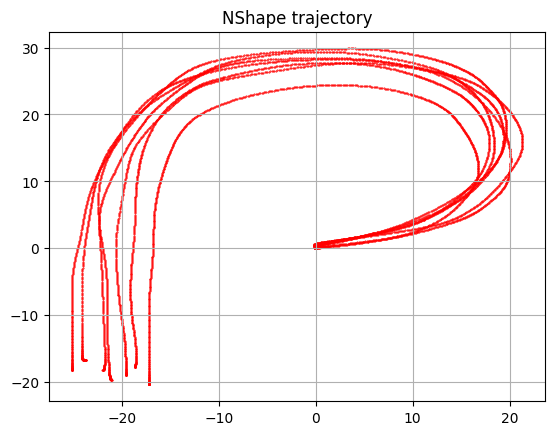

In [7]:
plt.scatter(traj_dynamics[:, 0], traj_dynamics[:, 1], c='r', marker = '.', s=0.8)
plt.title('NShape trajectory')
plt.grid()

#### 2.3.2 Fitting gmm:

In [8]:
gmm = GMM(n_components=4, random_state=0)
gmm.from_samples(traj_dynamics)

# getting cluster assignments for each data point:
traj_k = np.argmax(gmm.to_responsibilities(traj_dynamics), axis=1)

#### 2.3.3 Predicting Velocities using GMR:

In [9]:
def pred_vel(trajectory_name = 'Sine', grid_size = 50):
    
    """
    This function predicts the velocity of the trajectory using GMM.
    Input: trejectory_name: name of the trajectory.
    grid_size: number of points in each dimension.
    
    Output: a list of arrays [pred_vel_u, pred_vel_v]
            pred_vel_u: u component, shape = (grid_size, grid_size)
            pred_vel_v: v component, shape = (grid_size, grid_size)
    """
    
    traj_dynamics = get_traj_data(trajectory_name)
    # Define the range and number of points for x and y
    x_start, x_end = traj_dynamics[:, 0].min(), traj_dynamics[:, 0].max()
    y_start, y_end = traj_dynamics[:, 1].min(), traj_dynamics[:, 1].max()

    # Generate the grid dataset using np.linspace
    x = np.linspace(x_start-10, x_end+10, grid_size)
    y = np.linspace(y_start-10, y_end+10, grid_size)

    # Create a meshgrid from the x and y values
    x_grid, y_grid = np.meshgrid(x, y)

    # Flatten the grids to create the dataset
    x_dataset = x_grid.flatten()
    y_dataset = y_grid.flatten()

    # Combine x and y values to create the final 2D dataset
    test_pos = np.column_stack((x_dataset, y_dataset))
    
    # predict velocity using gmr:
    pred_vel = gmm.predict(np.array([0, 1]), test_pos)

    # u component of velocity
    pred_vel_u = pred_vel[:, 0].reshape(x_grid.shape)

    # v component of velocity
    pred_vel_v = pred_vel[:, 1].reshape(x_grid.shape)

    return [x_grid, y_grid, pred_vel_u, pred_vel_v]

In [10]:
pos_vel = pred_vel('PShape')

#### 2.3.3 Plotting Predicted Velocities Streamlines:

In [11]:
# Function for plotting Guassian Ellipses:

def plot_gmm(mean, cov, color='k'):
    """Plot a single gaussian component"""
    # Get the eigenvalues and eigenvectors
    eigen_vals, eigen_vecs = np.linalg.eig(cov)

    # Get the index of the largest eigenvalue 
    idx = eigen_vals.argsort()[::-1] 
    eigen_vals, eigen_vecs = eigen_vals[idx], eigen_vecs[:,idx]

    theta = np.degrees(np.arctan2(eigen_vecs[:, 0][::-1]))

    # Ellipse properties 
    width, height = 2 * np.sqrt(eigen_vals)
    ellipse = patches.Ellipse(mean, width, height, angle=theta, facecolor='none', edgecolor=color)
    # ellipse.set_linestyle('--')
    ellipse.set_linewidth(4)
    return ellipse

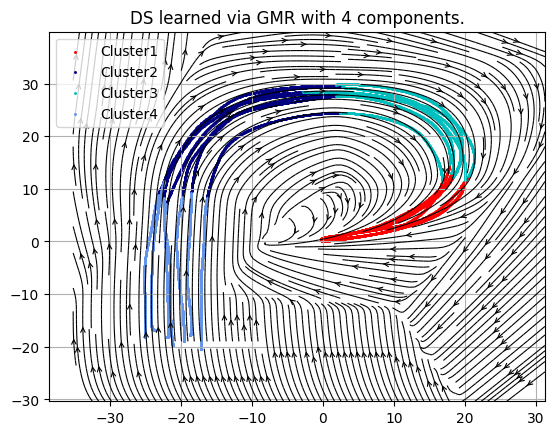

In [12]:
# color for each component:
color_iter_data = itertools.cycle(["red", "navy", "c", "cornflowerblue", "gold",\
    "darkorange", "green", "blue", "purple", "pink"])

# color for Gaussian ellipses:
color_iter_gmm = itertools.cycle(["green", "yellow", "black", "cornflowerblue", "gold"])


# plt.figure(figsize=(10, 10))
fig, ax = plt.subplots()
# plotting clustered datapoints for each component in loop:
for i in range(gmm.n_components):
    ax.scatter(traj_dynamics[:, :2][traj_k == i, 0],\
        traj_dynamics[:, :2][traj_k == i, 1], s=5,\
        c=next(color_iter_data), marker='.', label='Cluster' + str(i + 1))

# plotting Gaussian ellipses for each component in a loop:
# for i in range(gmm.n_components):
    # ellipse = plot_gmm(gmm.means[i], gmm.covariances[i], color=next(color_iter_gmm))
    # ax.add_patch(ellipse)

# plottin streamlines for predicted velocities:
ax.streamplot(pos_vel[0], pos_vel[1], pos_vel[2], pos_vel[3],\
    density=2.5, linewidth=0.8, color='k', arrowsize=0.8, arrowstyle='->')

plt.title('DS learned via GMR with ' + str(gmm.n_components) + ' components.')
plt.legend(loc = 'upper left', fontsize=10)
plt.grid()

plt.show()

# 3. SEDS Algorithm to fit the GMR on the dataset:
SEDS Solver using `ipyopt`:\
Please refer to [ipyopt](https://pypi.org/project/ipyopt/); a python implementation  of [ipopt](https://github.com/coin-or/Ipopt).

## 3.1 MSE Optimization: Not Implemented.

## 3.2 Alternative MSE Optimization: Not Implemented.

1. Derivatives w.r.t Means $\mu_x^k$
\begin{equation}
\frac{\partial J}{\partial \mu_{x, i}^k} = \frac{1}{2M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{\partial J}{\partial \hat {\dot x}^{t, m}}
\frac{\partial \hat {\dot x}^{t, m}}{\partial \mu_{x, i}^k}
 \ \ \forall i \ \epsilon \ 1...d, \ \ \ \forall k \ \epsilon \ 1...K
\end{equation}

where,

\begin{equation}
\frac{\partial J}{\partial \hat {\dot x}^{t, m}} = \sum_{m=1}^{M} \sum_{t=0}^{T^n}
(\hat {\dot x}^{t, m} - \dot x^{t, m})^T
\end{equation}

\begin{equation}
\tag{8}
\!
\begin{aligned}
\hat {\dot x} & = f(x)\\
& = \sum_{k=1}^{K} \gamma_k(x) (A^k_x + b^k)
\end{aligned}
\end{equation}

where,

\begin{equation}
\tag{6}
\!
\begin{aligned}
A^k & = \Sigma_{\dot x x}^k(\Sigma_{x}^k)^{-1}\\
b^k & = \mu_{\dot x}^k - A^k \mu_x^k\\

\gamma_k & = \frac{\pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}
{\sum_{k=1}^{K} \pi_k p(x|\mu_x^k, \Sigma_{xx}^k)}\\
\end{aligned}
\end{equation}

\begin{equation}
\frac{\partial \hat {\dot x}^{t, m}}{\partial \mu_{x, i}^k} = \gamma(x^{t, m})
\left( (x^{t, m} - \mu_x^k)^T (\Sigma_x^k)^{-1} \mathbb(0^{\{i\}})\right)
\left( A^kx^{t, m} - \hat {\dot x}^{t, m} \right)
\end{equation}


## 3.3 Likelihood Optimization: Not Implemented.

### 3.3.1 Objective Function Formulation:

\begin{equation*}
\begin{aligned}
& \underset{\Theta_{GMR}} {\text{min}}
&& J(\Theta_{GMR}) = -\frac {1}{L}\sum_{m=1}^{M}\sum_{t=0}^{T_m}
\log p(x^{t,m},\dot x^{t, m}|\Theta_{GMR})\\

& \text{subject to}
&& (\mathbf{a})\ \ b^k = -A^kx^*\\
&&& (\mathbf{b})\ \ A^k + (A^k)^T \prec 0\\
&&& (\mathbf{c})\ \ \Sigma^k \succ 0 \hspace{60pt} \forall \ k = 1, ..., K\\
&&& (\mathbf{d})\ \ 0 < \pi_k \leq 1\\
&&& (\mathbf{d})\ \ \Sigma_{k=1}^K \pi_k = 1

\end{aligned}
\end{equation*}


In [13]:
# initialize gmm for dynamics:
gmm_dynamics = GMM(n_components=2, random_state=0)
gmm_dynamics.from_samples(traj_dynamics)
K = gmm_dynamics.n_components

# piors for the datapoints; shape (n_datapoints, n_components)
traj_priors = gmm_dynamics.to_responsibilities(traj_dynamics)

# means of the trajectory; shape (n_features, n_components)
traj_means = gmm_dynamics.means

# covariances of the trajectory; shape (n_components, n_features, n_features)
traj_covariances = gmm_dynamics.covariances

Please refer to this [`GMM` class](https://github.com/AlexanderFabisch/gmr/blob/master/gmr/gmm.py) and its methods for more details: 

In [14]:
traj = lasa.CShape
M = len(traj.demos) # number of demonstrations

In [15]:
# joint probability of position and velocity:
# shape (n_samples, )
joint_prob_dotx_x = gmm_dynamics.to_probability_density(traj_dynamics)

# objective function J:
obj_fun = -1 * np.sum(np.log(joint_prob_dotx_x))/ M

# conditional probability 'P' over priors, shape = (n_samples, n_components):
cond_prob = [MVN(traj_means[k], traj_covariances[k]).to_probability_density(traj_dynamics)\
                for k in range(K)]
cond_prob = np.column_stack((cond_prob[0], cond_prob[1]))

### 3.3.2 Derivatives w.r.t Priors $\pi^k:$

where, $\mathcal{P}^{t, m}$ = $\mathcal{P}(\xi^{t, m}, \dot \xi^{t, m}|\theta)$

In [16]:
dJdPrior = [-1 * np.sum((cond_prob[:, k]/joint_prob_dotx_x) - 1) / M for k in range(K)]

### 3.3.3 Derivatives w.r.t Means $\mu_x^k:$

\begin{equation}
\frac{\partial J}{\partial \mu_{x, i}^k} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{\mathcal{P}(k) \mathcal{P}(x^{t, m}, \dot x^{t, m}|k)}{\mathcal{P}^{t, m}}
(\mathbf{0^{\{ i\}}})^T [ \mathbf{I}\ \ \ \ \ (A^k)^T] (\Sigma^k)^{-1} ([x^{t, m}\ \ \ \dot x^{t, m}] - \mu^k)
\ \ \ \ \ \ \ \forall i \ \epsilon \ 1....d\\
\end{equation}

where, $\mathbf{I}$ has the dimension of $d \times d$ and $\mathbf{0^{\{ i\}}}$ is a zero vector of dimension $d$ whose $i^{th}$ element is 1.

Term 1: $\frac{\mathcal{P}(k) \mathcal{P}(\xi^{t, n}, \dot \xi^{t, n};k)}{\mathcal{P}^{t, n}}$

Term 2: $[\mathbf{I}\ \ \ (A^k)^T]_{d \times 2d}(\Sigma^k)^{-1}_{2d\times 2d}([x^{t, m} \ \ \dot x^{t, m}] - \mu^k)_{2d\times 1}$:

In [17]:
# probability term for each GMM component (Term 1):
prob_term = [traj_priors[:, k]*cond_prob[:, k]/joint_prob_dotx_x for k in range(K)]


# calculating Term 2:
# dimension of the state space:
d = int(traj_dynamics.shape[1]/2)

# list of the matrices A for each component:
sigma_inv = [np.linalg.inv(traj_covariances[k]) for k in range(K)]
sigma_xx = [traj_covariances[k][:d, :d] for k in range(K)]
sigma_xdx = [traj_covariances[k][d:, :d] for k in range(K)]
mat_A = [np.matmul(sigma_xdx[k], np.linalg.inv(sigma_xx[k])) for k in range(K)]

# Indentity matrix and A matrix for each component:
concat_I_A = [np.concatenate((np.eye(d), mat_A[k].T), axis=1) for k in range(K)]

# trajectory - means, a list of 'k' arrays of shape (n_samples, d):
traj_minus_mean = [traj_dynamics - traj_means[k] for k in range(K)]

# multiplying all the matrices::
matrix_term = [concat_I_A[k] @ sigma_inv[k] @ traj_minus_mean[k].T\
               for k in range(K)] 


# calculating the final expression:
# derivative of with respect to means:
# this is a list of 'k' arrays, each array is of shape (d, )
dJdmean = [prob_term[k][:, np.newaxis].T @ matrix_term[k].T for k in range(K)]

### 3.3.4 Derivatives w.r.t covariances:

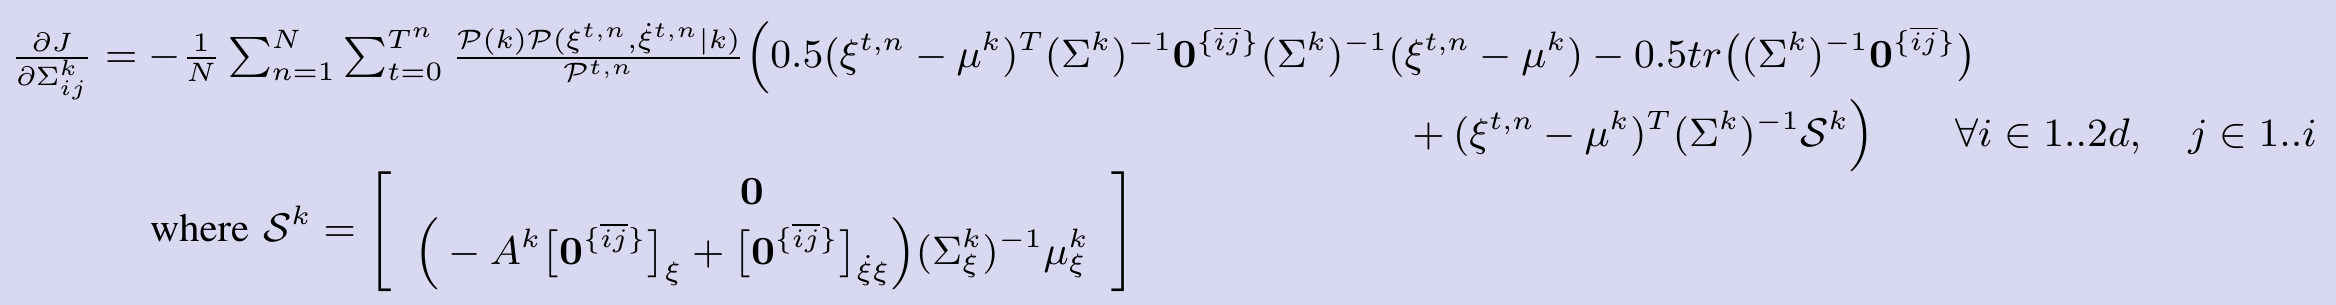

In [33]:
def dJ_dCovar(prob_term, traj_minus_mean, traj_means, traj_covariances, mat_A, M):
    sigma_inv = [np.linalg.inv(traj_covariances[k]) for k in range(K)]
    vec_1 = [(traj_minus_mean[k] @ sigma_inv[k]) for k in range(K)] # (n_samples, n_features)
    vec_2 = [(sigma_inv[k] @ traj_minus_mean[k].T).T for k in range(K)] # (n_samples, n_features)
    zero_mat = np.zeros((vec_1[0].shape[1], vec_2[0].shape[1]))
    vec_Sk = np.zeros((vec_1[0].shape[1], 1))
    d = int(vec_Sk.shape[0]/2)
    result_mat = zero_mat.copy()
    derivatives = []
    for k in range(K):
        for i in range(vec_1[0].shape[1]):
            for j in range(i+1):
                zero_mat[i, j] = 1
                covar_term = (0.5 * (vec_1[k] @ zero_mat) * vec_2[k]).sum(axis=1)[:, np.newaxis]
                trace_term = 0.5 * np.trace(sigma_inv[k] @ zero_mat)
                vec_Sk[d:] = (-1 * mat_A[k] @ zero_mat[:d, :d] + zero_mat[d:, :d])\
                                @ (sigma_inv[k][:d, :d] @ traj_means[k][:d][:, np.newaxis])
                vec_Sk_term = vec_1[k] @ vec_Sk
                result_mat[i, j] = -1 * (prob_term[k][:, np.newaxis].T \
                                    @ (covar_term - trace_term + vec_Sk_term)) / M
                zero_mat[i, j] = 0
        derivatives.append(result_mat + result_mat.T - np.diag(np.diag(result_mat)))
    return derivatives

## 3.4 Alternative Likelihood Optimization: Under Implementation.

### 3.4.1 Objective Function Formulation: (Completed)

\begin{equation}
\begin{aligned}
& \underset{\Theta_{GMR}} {\text{min}}
&& J(\Theta_{GMR}) = -\frac {1}{M}\sum_{m=1}^{M}\sum_{t=0}^{T_m}
\log p(x^{t,m},\dot x^{t, m}|\Theta_{GMR})\\
& \text{subject to}
&& A^k + (A^k)^T \prec 0 \ \ \ \ \ \ \ \forall k \ \epsilon \ 1...K\\
\end{aligned}
\end{equation}

where, 
\begin{equation}
\tag{3}
p(x^{t, m}, \dot x^{t, m}|\Theta_{GMR}) = \mathcal{P}^{t, m} =\sum_{k=1}^{K} \pi_k p(x^{t, m}, \dot x^{t, m}|\mu^k \Sigma^k)
\end{equation}

In [20]:
# gmm object:
gmm_dynamics = GMM(n_components=2, random_state=0)
gmm_dynamics.from_samples(traj_dynamics)
K = gmm_dynamics.n_components

# initialize gmm for position:
gmm_pos = GMM(n_components=2, random_state=1)
gmm_pos.from_samples(traj_dynamics[:, 2:])


# piors for the datapoints; shape (n_datapoints, n_components)
traj_priors = gmm_dynamics.to_responsibilities(traj_dynamics)

# means of the trajectory; shape (n_features, n_components)
traj_means = gmm_dynamics.means

# covariances of the trajectory; shape (n_components, n_features, n_features)
traj_covariances = gmm_dynamics.covariances

# getting trajectory data:
traj = lasa.CShape
M = len(traj.demos) # number of demonstrations
d = int(traj_dynamics.shape[1] / 2) # dimension of the state space
# joint probability of position and velocity of each datapoint; shape (n_samples, ):
joint_prob = gmm_dynamics.to_probability_density(traj_dynamics)

# objective function J:
obj_fun = -1 * np.sum(np.log(joint_prob))/ M

# conditional probability 'P' over priors, shape = (n_samples, n_components):
cond_prob = [MVN(traj_means[i], traj_covariances[i]).to_probability_density(traj_dynamics)\
                for i in range(gmm_dynamics.n_components)]
cond_prob = np.column_stack((cond_prob[0], cond_prob[1]))


### 3.4.2. Derivatives w.t.t log priors $\tilde \pi^k$

\begin{equation}
\frac{\partial J}{\partial \tilde \pi^k} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{\partial J}{\partial \mathcal{P}^{t, m}}
\frac{\partial \mathcal{P}^{t, n}}{\partial \pi^k}
\frac {{\partial \pi^k}}{\partial \tilde \pi^k} \ \ \ \ \ \ \ \forall k \ \epsilon \ 1...K
\end{equation}


$\ \ \ \ \ $ where,

\begin{equation}
\frac{\partial J}{\partial \mathcal{P}^{t, m}} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{1}{\mathcal{P}^{t, m}}
\end{equation}


\begin{equation}
\frac{\partial \mathcal{P}^{t, m}}{\partial \pi^k} = 
\mathcal P(x^{t, m}, \dot x^{t, m}|k) - \mathcal{P}^{t, m}
\end{equation}


\begin{equation}
\frac {{\partial \pi^k}}{\partial \tilde \pi^k} = 
e^{\tilde \pi^k}
\end{equation}


\begin{equation}
\tilde \pi^k = ln(\pi^k)
\end{equation}

In [21]:
# derivative of with respect to priors:

# derivative of obj function wrt joint prob:
dJ_dJoint_prob = -1 * np.sum(1/ joint_prob) / M

# derivative of joint prob wrt priors:
dJoint_prob_dPrior = [(cond_prob[:, k] - joint_prob) for k in range(K)]

# derivative of priors wrt to log priors:
log_traj_priors = np.log(traj_priors)
dPrior_dlogPrior = [np.exp(log_traj_priors[:, k]) for k in range(K)]

# derivative of obj function wrt priors:
dJ_dPrior = [-1 * np.sum(dJ_dJoint_prob * dJoint_prob_dPrior[k] * dPrior_dlogPrior[k]) / M for k in range(K)]

### 3.4.3 Derivatives w.r.t. Means $\mu_x^k$

\begin{equation}
\frac{\partial J}{\partial \mu_x^k} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{\mathcal{P}(k) \mathcal{P}(x^{t, m}, \dot x^{t, m}|k)}{\mathcal{P}^{t, m}}
[ \mathbf{I}\ \ \ \ \ (A^k)^T] (\Sigma^k)^{-1} ([x^{t, m}\ \ \ \dot x^{t, m}] - \mu^k)
\ \ \ \ \ \ \ \forall i \ \epsilon \ 1....d\\
\end{equation}

where, $\mathbf{I}$ has the dimension of $d \times d$. Note that, $\frac{\partial J}{\partial \mu_x^k}$ is a vector of dimension $d$ and each $\frac{\partial J}{\partial \mu_{x, i}^k}$ is in fact one element of this vector.

In [22]:
# probability term for each GMM component (Term 1):
prob_term = [traj_priors[:, k]*cond_prob[:, k]/joint_prob for k in range(K)]


# calculating Term 2:
# dimension of the state space:
d = int(traj_dynamics.shape[1]/2)

# list of the matrices A for each component:
sigma_xx = [traj_covariances[k][:d, :d] for k in range(K)]
sigma_dotx_x = [traj_covariances[k][d:, :d] for k in range(K)]
mat_A = [np.matmul(sigma_dotx_x[k], np.linalg.inv(sigma_xx[k])) for k in range(K)]

# Indentity matrix and A matrix for each component:
concat_I_A = [np.concatenate((np.eye(d), mat_A[k].T), axis=1) for k in range(K)]

# trajectory - means, a list of 'k' arrays of shape (n_samples, d):
traj_minus_mean = [traj_dynamics - traj_means[k] for k in range(K)]

# multiplying all the matrices::
matrix_term = [concat_I_A[k] @ sigma_inv[k] @ traj_minus_mean[k].T\
               for k in range(K)] 

# calculating the final expression:
# derivative of with respect to means:
# this is a list of 'k' arrays, each array is of shape (d, )
dJdmean = [prob_term[k][:, np.newaxis].T @ matrix_term[k].T for k in range(K)]

### 3.4.4 Derivatives w.r.t. $L^k = Chol(\Sigma^k)$:

\begin{equation}
\frac{\partial J}{\partial L_{ij}^k} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac{\partial J}{\partial \mathcal{P}^{t, m}}
\frac{\partial \mathcal{P}^{t, m}}{\partial L_{ij}^k}
\ \ \ \ \ \ 
\begin{cases} 
\forall i \ \epsilon \ 1...2d\\
\forall j \ \epsilon \ 1...i\\
\forall k \ \epsilon \ 1...K\\
\end{cases}

\end{equation}

where,

\begin{equation}
\frac{\partial \mathcal{P}^{t, m}}{\partial L_{ij}^k} = -\frac{1}{M} \sum_{m=1}^{M} \sum_{t=0}^{T^n}
\frac {\mathcal{P}(k) \mathcal{P}(x^{t, m}, \dot x^{t, m}|k) }{\mathcal{P}^{t, m}}
\left( 0.5(x^{t, n} - \mu^k)^T (\Sigma^k)^{-1} \Phi (\Sigma^k)^{-1} (x^{t, m} - \mu^k)
- 0.5 tr((\Sigma^k)^{-1} \Phi) +  (x^{t, m} - \mu^k)^T (\Sigma^k)^{-1} \mathcal{\tilde S^k} \right)
\end{equation}

where, $\Phi = \mathbf{0}^{\{ij\}}(L^k)^T + L^k(\mathbf{0}^{\{ij\}})^T $ with dimensions $2d \times 2d$, and the $2d$ dimensional vector $\tilde {\mathcal{S}}^k$ is given as:
\begin{equation}
\tilde {\mathcal{S}} =
\begin{bmatrix}
\mathbf{0}\\
( -A^k\Phi_x + \Phi_{\dot x x})(\Sigma_{xx}^k)^{-1}\mu_x^k\\
\end{bmatrix}_{2d \times 1}
\end{equation}




In [34]:
# Formulating the above expression:
# derivative of joint prob wrt L matrix:

def dJ_dLk(prob_term, traj_minus_mean, traj_means, traj_covariances, mat_A, M):
    sigma_inv = [np.linalg.inv(traj_covariances[k]) for k in range(K)]
    vec_1 = [(traj_minus_mean[k] @ sigma_inv[k]) for k in range(K)]
    vec_2 = [(sigma_inv[k] @ traj_minus_mean[k].T).T for k in range(K)]
    mat_zero = np.zeros((vec_1[0].shape[1], vec_2[0].shape[1]))
    mat_L = [np.cholesky(traj_covariances[k]) for k in range(K)]
    vec_Sk = np.zeros((vec_1[0].shape[1], 1))
    d = int(vec_Sk.shape[0]/2)
    result_mat = mat_zero.copy()
    derivatives = []
    for k in range(K):
        for i in range(vec_1[0].shape[1]):
            for j in range(i+1):
                mat_zero[i, j] = 1
                mat_Phi = mat_zero @ mat_L[k].T + mat_L[k] @ mat_zero.T
                covar_term = (0.5 * (vec_1[k] @ mat_Phi) * vec_2[k]).sum(axis=1)[:, np.newaxis]
                trace_term = 0.5 * np.trace(sigma_inv[k] @ mat_Phi)
                vec_Sk[d:] = (-1 * mat_A[k] @ mat_Phi[:d, :d] + mat_Phi[d:, :d])\
                                @ (sigma_inv[k][:d, :d] @ traj_means[k][:d][:, np.newaxis])
                vec_Sk_term = vec_1[k] @ vec_Sk
                result_mat[i, j] = -1 * (prob_term[k][:, np.newaxis].T \
                                @ (covar_term - trace_term + vec_Sk_term)) / M
                mat_zero[i, j] = 0
        derivatives.append(result_mat + result_mat.T - np.diag(np.diag(result_mat)))
    return derivatives

### 3.4.5 Derivatives w.r.t constraints:

We use [Sylvester's crieterion](https://en.wikipedia.org/wiki/Sylvester%27s_criterion) to ensure negative definiteness of the matrix $A$ as follows:

Let matrix $B^k = A^k + (A^k)^T$, and the optimization constraint can we written as:

\begin{equation}
\mathcal{C}_{(k-1)d + c} = (-1)^{c+1} |B_{}|
\end{equation}

In [ ]:
#  matrix B:
mat_B = [mat_A[k] + mat_A[k].T for k in range(K)]



# References: